In [1]:
#Importa librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import pickle  



DATA COLLECTION

Datos de Yahoo Finance

In [2]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Para el Sp500 utilizo los datos a partir del año 2000, ya que en años anteriores la composición por industria del SP500 era bastante diferente. A partir de ese año hay importnate participación del sector teconología. Hago lo mismo para las otras variables

In [3]:
start_date = '2000-01-01'
end_date = '2024-04-26'

sp500 = sp500.history(period="max")
sp500 =sp500.loc[start_date:end_date].copy ()
oil = oil.history(period="max")
oil = oil.loc[start_date:end_date].copy ()
brent = brent.history(period="max") 
brent = brent.loc[start_date:end_date:].copy ()


In [4]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [5]:
sp500 = sp500.drop(columns=['Dividends', 'Stock Splits'])
sp500.index= sp500.index.tz_localize(None) # remove timezone

In [6]:
#Guardar el dataset en un archivo csv   
sp500.to_csv('sp500.csv', index=True)

In [7]:
#Hago lo mismo con el resto de los activos
oil = oil.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
oil.index= oil.index.tz_localize(None) # remove timezone
oil.head()

,Close
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


In [8]:
# Renombo la columna 'Close' a 'Close_oil' en el DataFrame 'oil' para que no se confunda con la del S&P 500
oil.rename(columns={'Close': 'Close_oil'}, inplace=True)

# Muestra las primeras filas para verificar el cambio
print(oil.head())


            Close_oil
Date                 
2000-08-23  32.049999
2000-08-24  31.629999
2000-08-25  32.049999
2000-08-28  32.869999
2000-08-29  32.720001


In [9]:
# Asumiendo que 'df' es tu DataFrame y 'oil' es la columna con los datos de precios de petróleo
oil['oil_daily_changes'] = oil['Close_oil'].pct_change() * 100  # Multiplicar por 100 para convertir a porcentaje


Datos de FRED (Banco de la Reserva Federal de St. Louis)

In [10]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES # OJO --->>>> Estas variables miden el riesgo de crédito y el apetito por el riesgo de los inversores 

# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
#OJO --->>>> Esta variables miden el cambio en las expectativas de inflación y los movimientos de tasas de interés

# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.
#(GVZCLS)= CBOE Gold ETF Volatility Index 

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS','GVZCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




In [11]:
#Sacar los cambios diarios de las variables macroeconomicas
changes_daily = macroeconomic_df.diff()

# Renombrar las columnas para indicar que representan cambios diarios
changes_daily.columns = [f"{col}_daily_change" for col in macroeconomic_df.columns]

# Concatenar los cambios diarios de vuelta al DataFrame original
macroeconomic_df = pd.concat([macroeconomic_df, changes_daily], axis=1)

In [12]:
# Contar los valores nulos en cada columna
null_counts_macro = macroeconomic_df.isnull().sum()
print("Conteo de valores nulos por columna antes de limpiar:\n", null_counts_macro)

# Eliminar las filas con valores nulos o NaN
macroeconomic_df_clean = macroeconomic_df.dropna()

# Contar de nuevo los valores nulos en cada columna
null_counts_clean = macroeconomic_df_clean.isnull().sum()
print("Conteo de valores nulos por columna después de limpiar:\n", null_counts_clean)

# Guardar el DataFrame limpio a un archivo CSV
macroeconomic_df_clean.to_csv("macroeconomic_df_clean.csv")


Conteo de valores nulos por columna antes de limpiar:
 DAAA                             3625
AAA10Y                           3674
DBAA                             4384
BAA10Y                           4421
BAMLH0A0HYM2                     6870
BAMLH0A2HYB                      6870
BAMLH0A3HYC                      6870
BAMLHE00EHYIOAS                  7127
T10Y2Y                           2028
T10Y3M                           3419
T5YIE                            8667
DEXUSEU                          7652
DEXCHUS                          3191
DEXCAUS                           625
DEXMXUS                          6363
VIXCLS                           5344
GVZCLS                           9997
DAAA_daily_change                4101
AAA10Y_daily_change              4198
DBAA_daily_change                4836
BAA10Y_daily_change              4909
BAMLH0A0HYM2_daily_change        6958
BAMLH0A2HYB_daily_change         6958
BAMLH0A3HYC_daily_change         6958
BAMLHE00EHYIOAS_daily_change     

In [13]:
# Unir macroeconomic_df con sp500 basado en sus índices de fecha
AllVar_df =sp500.join(macroeconomic_df_clean, how='inner')

print(AllVar_df.index)
AllVar_df = AllVar_df.sort_index()

DatetimeIndex(['2008-06-04', '2008-06-05', '2008-06-06', '2008-06-09',
               '2008-06-10', '2008-06-11', '2008-06-12', '2008-06-13',
               '2008-06-16', '2008-06-17',
               ...
               '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
               '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24',
               '2024-04-25', '2024-04-26'],
              dtype='datetime64[ns]', name='Date', length=3732, freq=None)


In [14]:
# Unir el DataFrame 'oil' al 'AllVar_df' que ya contiene datos combinados de 'macroeconomic_df' y 'sp500'
# Asegúrate de que 'oil' está indexado adecuadamente, si es necesario
if 'Date' in oil.columns:
    oil.set_index('Date', inplace=True)

# Especificando sufijos para resolver el conflicto de nombres de columnas
AllVar_df = AllVar_df.join(oil, how='inner', lsuffix='_AllVar', rsuffix='_oil')

# Mostrar las primeras filas para verificar las nuevas columnas
print(AllVar_df.head())

                   Open         High          Low        Close      Volume  \
Date                                                                         
2008-06-04  1376.260010  1388.180054  1371.739990  1377.199951  4338640000   
2008-06-05  1377.479980  1404.050049  1377.479980  1404.050049  4350790000   
2008-06-06  1400.060059  1400.060059  1359.900024  1360.680054  4771660000   
2008-06-09  1360.829956  1370.630005  1350.619995  1361.760010  4404570000   
2008-06-10  1358.979980  1366.839966  1351.560059  1358.439941  4635070000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  \
Date                                                  ...   
2008-06-04  5.64    1.66  7.02    3.04          6.79  ...   
2008-06-05  5.69    1.63  7.07    3.01          6.63  ...   
2008-06-06  5.61    1.67  6.98    3.04          6.68  ...   
2008-06-09  5.58    1.56  6.96    2.94          6.58  ...   
2008-06-10  5.66    1.55  7.05    2.94          6.49  ...   

            T10Y3M_daily_

AUTOARIMA

In [15]:
start_date_All = AllVar_df.index.min()
end_date_All = AllVar_df.index.max()
print(f"Los datos comienzan el: {start_date_All}")
print(f"Los datos terminan el: {end_date_All}")

Los datos comienzan el: 2008-06-04 00:00:00
Los datos terminan el: 2024-04-26 00:00:00


In [16]:
fecha_inicio = '2014-04-30'
test_size_Control=0.2

<Axes: xlabel='Date'>

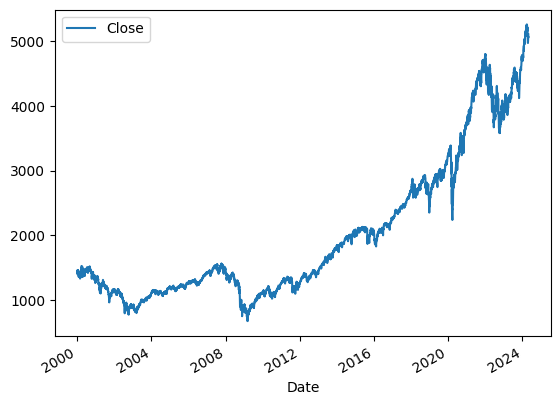

In [17]:
#Se eliminan las columnas que no se van a utilizar
# Crear un nuevo DataFrame seleccionando solo las columnas 'Date' y 'Close'
sp500_ARIMA = sp500.iloc[:, [3]]
sp500_ARIMA.plot(y="Close", use_index=True)

In [18]:
sp500_ARIMA = sp500_ARIMA.loc[fecha_inicio:]#ya que al juntar todos los datos para SARIMAX que implemento luego empiezan en esa fecha
sp500_ARIMA.head()

,Close
Date,
2014-04-30,1883.949951
2014-05-01,1883.680054
2014-05-02,1881.140015
2014-05-05,1884.660034
2014-05-06,1867.719971


In [19]:
#Verificar si hay valores nulos
missing_values = sp500_ARIMA.isnull().sum()
print(missing_values)

Close    0
dtype: int64


In [20]:
#Guardar el dataset en un archivo csv   
sp500_ARIMA.to_csv('sp500_yahoo2000.csv', index=True)

In [21]:
# Se convierte el índice a tipo datetime
sp500_ARIMA.index = pd.to_datetime(sp500_ARIMA.index)
# Asegurar que el índice esté en formato de fecha y ordenado
sp500_ARIMA.sort_index(inplace=True)


In [22]:
# Preparación de los datos
train_size_arima1 = int(len(sp500_ARIMA) * (1-test_size_Control))
train_arima1, test_arima1 = sp500_ARIMA['Close'][:train_size_arima1], sp500_ARIMA['Close'][train_size_arima1:]


In [23]:
# Ajustar el modelo AutoARIMA
model_arima1 = auto_arima(train_arima1, seasonal=False, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True)

# Guardar el modelo
pickle.dump(model_arima1, open('ARIMA1_Close_best_model.pkl', 'wb'))
print("Mejor modelo ARIMA1 guardado:")
print(model_arima1.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19520.315, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19659.310, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19623.572, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19628.412, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19660.121, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19617.672, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19618.720, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19618.572, Time=1.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19618.609, Time=1.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19619.833, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19617.485, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19568.962, Time=0.87 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19523.818, Time=1.71 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=19521.703, Time=0.49 sec

Best model:  ARIMA

In [24]:
# Predicciones: asumimos que test_arima1 es el conjunto de datos para validar el modelo
n_periods = len(test_arima1)
predicted_values_arima1 = model_arima1.predict(n_periods=n_periods)
predicted_values_array_arima1 = np.array(predicted_values_arima1)

c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [25]:
# Crear y guardar DataFrame con resultados
test_df_arima1 = pd.DataFrame({
    'Fecha_ARIMA1': pd.to_datetime(sp500_ARIMA.index[train_size_arima1:]),
    'Valor_Real_ARIMA1': test_arima1,
    'Prediccion_ARIMA1': predicted_values_array_arima1
})
#test_df_arima1.to_csv('ARIMA1_test_vs_predicciones.csv', index=False)

# Opcional: guardar solo los valores reales para comparar posteriormente
#valores_reales_df_arima1 = test_df_arima1[['Fecha_ARIMA1', 'Valor_Real_ARIMA1']]
#valores_reales_df_arima1.to_csv('ARIMA1_valores_reales_test.csv', index=False)

#Usar f-strings para formatear el nombre del archivo incluyendo las variables
nombre_archivo_completo = f'ARIMA1_test_vs_predicciones_{fecha_inicio}_testsize{test_size_Control}.csv'
test_df_arima1.to_csv(nombre_archivo_completo, index=False)

In [26]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test_arima1 = mean_squared_error(test_arima1, predicted_values_array_arima1)
rmse_test_arima1 = np.sqrt(mse_test_arima1)
mae_test_arima1 = mean_absolute_error(test_arima1, predicted_values_array_arima1)

print(f'ARIMA1 Test - MSE: {mse_test_arima1}, RMSE: {rmse_test_arima1}, MAE: {mae_test_arima1}')

ARIMA1 Test - MSE: 177180.57751195124, RMSE: 420.9282332084072, MAE: 374.15201808721434


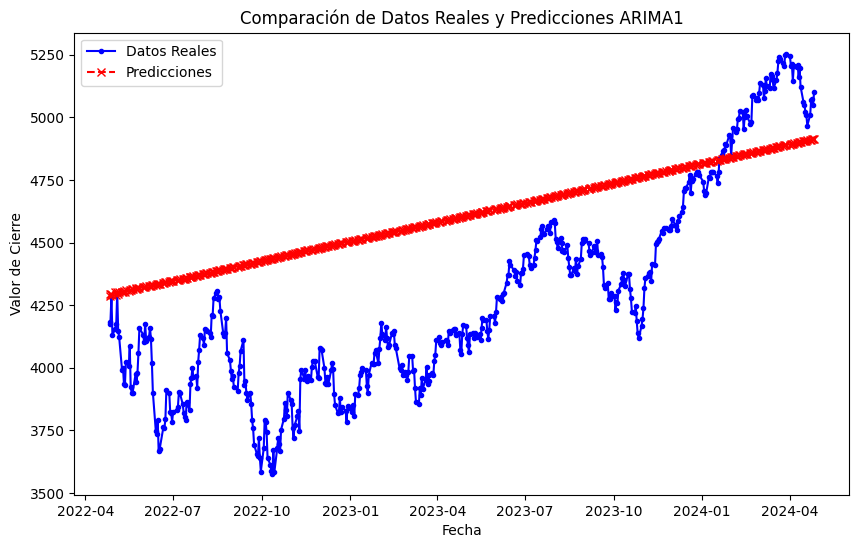

In [27]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(test_df_arima1['Fecha_ARIMA1'], test_df_arima1['Valor_Real_ARIMA1'], label='Datos Reales', marker='.', color='blue')
plt.plot(test_df_arima1['Fecha_ARIMA1'], test_df_arima1['Prediccion_ARIMA1'], label='Predicciones', marker='x', linestyle='--', color='red')
plt.title('Comparación de Datos Reales y Predicciones ARIMA1')
plt.xlabel('Fecha')
plt.ylabel('Valor de Cierre')
plt.legend()
plt.show()

Intentamos correr un SARIMAX, a ver si las vriables exogenas agregan poder de prediccion

In [28]:
null_counts = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna:\n", null_counts)



Conteo de valores nulos por columna:
 Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
DAAA                            0
AAA10Y                          0
DBAA                            0
BAA10Y                          0
BAMLH0A0HYM2                    0
BAMLH0A2HYB                     0
BAMLH0A3HYC                     0
BAMLHE00EHYIOAS                 0
T10Y2Y                          0
T10Y3M                          0
T5YIE                           0
DEXUSEU                         0
DEXCHUS                         0
DEXCAUS                         0
DEXMXUS                         0
VIXCLS                          0
GVZCLS                          0
DAAA_daily_change               0
AAA10Y_daily_change             0
DBAA_daily_change               0
BAA10Y_daily_change             0
BAMLH0A0HYM2_daily_change       0
BAMLH0A2HYB_daily_change        0
BAMLH0A3HY

In [29]:
# Obtén una lista con todos los nombres de las columnas en el DataFrame
column_names = AllVar_df.columns.tolist()
print("Nombres de columnas en AllVar_df:", column_names)


Nombres de columnas en AllVar_df: ['Open', 'High', 'Low', 'Close', 'Volume', 'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change', 'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change', 'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'VIXCLS_daily_change', 'GVZCLS_daily_change', 'Close_oil', 'oil_daily_changes']


In [30]:
AllVar_df = AllVar_df.loc[fecha_inicio:]

In [31]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,Close_oil,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-30,1877.099976,1885.199951,1872.689941,1883.949951,3779230000,4.21,1.54,4.83,2.16,3.71,...,-0.05,0.01,0.0062,0.0013,-0.0007,-0.0320,-0.30,0.21,99.739998,-1.520538
2014-05-01,1884.390015,1888.589966,1878.040039,1883.680054,3416740000,4.16,1.53,4.77,2.14,3.75,...,-0.04,0.00,-0.0003,0.0000,0.0009,-0.0310,-0.16,-0.37,99.419998,-0.320834
2014-05-02,1885.300049,1891.329956,1878.500000,1881.140015,3159560000,4.12,1.52,4.74,2.14,3.73,...,-0.02,-0.01,-0.0003,0.0000,0.0008,-0.0540,-0.34,-0.30,99.760002,0.341988
2014-05-05,1879.449951,1885.510010,1866.770020,1884.660034,2733730000,4.16,1.53,4.78,2.15,3.74,...,0.02,-0.03,0.0020,-0.0138,-0.0018,0.0095,0.38,0.66,99.480003,-0.280672
2014-05-06,1883.689941,1883.689941,1867.719971,1867.719971,3327260000,4.13,1.52,4.76,2.15,3.72,...,-0.02,-0.01,0.0040,-0.0198,-0.0065,-0.0055,0.51,-0.49,99.500000,0.020101


In [32]:
#Seleccionar las columnas que se van a utilizar
selected_columns = ['VIXCLS', 'GVZCLS', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change', 'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change', 'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'oil_daily_changes']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_arimax1 = AllVar_df[selected_columns]

y_arimax1= AllVar_df['Close']

In [33]:
# Se convierte el índice a tipo datetime
X_arimax1.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
X_arimax1.sort_index(inplace=True)

In [34]:
# Se convierte el índice a tipo datetime
y_arimax1.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
y_arimax1.sort_index(inplace=True)

In [35]:
# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_arimax1 = int(len(AllVar_df) * (1-test_size_Control))
y_train_arimax1 = y_arimax1.iloc[:train_size_arimax1]
X_train_arimax1 = X_arimax1.iloc[:train_size_arimax1]

y_test_arimax1 = y_arimax1.iloc[train_size_arimax1:]
X_test_arimax1 = X_arimax1 .iloc[train_size_arimax1:]


In [36]:
# Ajustar el modelo arimax1
arimax1 = auto_arima(y_train_arimax1, X_train_arimax1, seasonal=False,
                     trace=True, error_action='ignore',
                     suppress_warnings=True, stepwise=True,
                     information_criterion='aic')  # Utilizando AIC para la selección del modelo

# Ver el resumen del modelo arimax1
print(arimax1.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16325.535, Time=3.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16352.092, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16354.036, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16354.043, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16360.210, Time=1.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16340.164, Time=3.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16344.046, Time=2.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16309.628, Time=3.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16321.015, Time=3.00 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=16314.742, Time=4.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16309.352, Time=3.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16312.428, Time=4.27 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=16313.400, Time=4.49 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=16315.959, Time=4.48 sec
 ARIMA(2,1,4)(0,0,0

In [43]:
#Seleccionar solo las variables significativas (p-values < 0.05)
selected_columns = ['VIXCLS', 'GVZCLS','BAMLH0A0HYM2_daily_change','BAMLHE00EHYIOAS_daily_change', 'T5YIE_daily_change','DEXUSEU_daily_change','oil_daily_changes']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_arimax1_new = AllVar_df[selected_columns]

y_arimax1_new= AllVar_df['Close']

In [44]:
# Se convierte el índice a tipo datetime
X_arimax1_new.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
X_arimax1_new.sort_index(inplace=True)

In [45]:
# Se convierte el índice a tipo datetime
y_arimax1_new.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
y_arimax1_new.sort_index(inplace=True)

In [46]:
# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_arimax1_new = int(len(AllVar_df) * (1-test_size_Control))
y_train_arimax1_new = y_arimax1_new.iloc[:train_size_arimax1_new]
X_train_arimax1_new = X_arimax1_new.iloc[:train_size_arimax1_new]

y_test_arimax1_new = y_arimax1_new.iloc[train_size_arimax1_new:]
X_test_arimax1_new = X_arimax1_new.iloc[train_size_arimax1_new:]


In [47]:
# Ajustar el modelo arimax1
arimax1_new = auto_arima(y_train_arimax1_new, X_train_arimax1_new, seasonal=False,
                     trace=True, error_action='ignore',
                     suppress_warnings=True, stepwise=True,
                     information_criterion='aic')  # Utilizando AIC para la selección del modelo

# Ver el resumen del modelo arimax1
print(arimax1_new.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16330.588, Time=2.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16354.093, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16356.082, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16356.083, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16362.077, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16345.826, Time=2.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16349.155, Time=1.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16312.183, Time=2.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16326.451, Time=2.30 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=16316.204, Time=2.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16312.782, Time=2.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16314.402, Time=2.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16316.776, Time=2.67 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=16314.751, Time=2.73 sec
 ARIMA(3,1,2)(0,0,0

In [48]:
# Asegúrate de que el número de períodos de predicción coincide con la longitud del conjunto de prueba
predictions_arimax1_new = arimax1_new.predict(n_periods=len(y_test_arimax1_new), X=X_test_arimax1_new)


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [49]:
# Verificar si hay índices duplicados
print("Índices duplicados en X_test:", X_test_arimax1_new.index.duplicated().any())
print("Índices duplicados en y_test:", y_test_arimax1_new.index.duplicated().any())

# Asegúrate de que los índices estén alineados
print("Índices alineados:", (X_test_arimax1_new.index == y_test_arimax1_new.index).all())


Índices duplicados en X_test: False
Índices duplicados en y_test: False
Índices alineados: True


In [50]:
# Verificar los tipos de datos y el tamaño de los conjuntos
print("Tipos de datos en X_test_arimax1_new:", X_test_arimax1_new.dtypes)
print("Tamaño de X_test_arimax1_new:", len(X_test_arimax1_new))

print("Tipo de datos en y_test_arimax1_new:", y_test_arimax1_new.dtype)
print("Tamaño de y_test_arimax1_new:", len(y_test_arimax1_new))

# Asumiendo que predictions_arimax1_new es un array NumPy
print("Tipo de datos en predictions_arimax1_new:", predictions_arimax1_new.dtype)
print("Tamaño de predictions_arimax1_new:", len(predictions_arimax1_new))


Tipos de datos en X_test_arimax1_new: VIXCLS                          float64
GVZCLS                          float64
BAMLH0A0HYM2_daily_change       float64
BAMLHE00EHYIOAS_daily_change    float64
T5YIE_daily_change              float64
DEXUSEU_daily_change            float64
oil_daily_changes               float64
dtype: object
Tamaño de X_test_arimax1_new: 469
Tipo de datos en y_test_arimax1_new: float64
Tamaño de y_test_arimax1_new: 469
Tipo de datos en predictions_arimax1_new: float64
Tamaño de predictions_arimax1_new: 469


In [51]:
X_test_arimax1_new.head()

,VIXCLS,GVZCLS,BAMLH0A0HYM2_daily_change,BAMLHE00EHYIOAS_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,oil_daily_changes
Date,,,,,,,
2022-04-29,33.40,19.83,0.10,0.04,-0.09,0.0037,-0.635913
2022-05-03,29.25,19.71,-0.08,0.05,0.00,0.0011,-2.624317
2022-05-04,25.42,18.81,0.13,0.05,0.03,0.0007,5.272916
2022-05-05,31.20,19.36,-0.07,0.00,-0.01,-0.0032,0.417405
2022-05-06,30.19,18.71,0.15,0.17,-0.01,0.0065,1.394785


In [52]:
y_test_arimax1_new_df=y_test_arimax1_new.to_frame()

In [53]:
y_test_arimax1_new_df.head()

,Close
Date,
2022-04-29,4131.930176
2022-05-03,4175.479980
2022-05-04,4300.169922
2022-05-05,4146.870117
2022-05-06,4123.339844


In [54]:
predictions_arimax1_new_df=predictions_arimax1_new.to_frame()

In [55]:
predictions_arimax1_new_df.head()

,0
1873,4252.650881
1874,4319.914381
1875,4350.951901
1876,4285.082288
1877,4282.536523


In [56]:
# Cambiar directamente el nombre de la primera columna
predictions_arimax1_new_df.columns = ['Prediccion'] + predictions_arimax1_new_df.columns[1:].tolist()

# Verificar los cambios
print(predictions_arimax1_new_df.head())


       Prediccion
1873  4252.650881
1874  4319.914381
1875  4350.951901
1876  4285.082288
1877  4282.536523


In [57]:
# Verificar el tamaño de ambos DataFrames para asegurar que coinciden
print("Tamaño de predictions_arimax1_new_df:", len(predictions_arimax1_new_df))
print("Tamaño de y_test_arimax1_new:", len(y_test_arimax1_new_df))


Tamaño de predictions_arimax1_new_df: 469
Tamaño de y_test_arimax1_new: 469


In [58]:
# Asignar el índice de fechas de y_test_arimax1_new al DataFrame de predicciones
predictions_arimax1_new_df.index = y_test_arimax1_new.index

# Verificar los cambios mostrando las primeras filas del DataFrame actualizado
print(predictions_arimax1_new_df.head())


             Prediccion
Date                   
2022-04-29  4252.650881
2022-05-03  4319.914381
2022-05-04  4350.951901
2022-05-05  4285.082288
2022-05-06  4282.536523


In [60]:
# Convertir índices a datetime si aún no están convertidos
predictions_arimax1_new_df.index = pd.to_datetime(predictions_arimax1_new_df.index)
y_test_arimax1_new_df.index = pd.to_datetime(y_test_arimax1_new_df.index)


In [61]:
combined_df = pd.concat([predictions_arimax1_new_df, y_test_arimax1_new_df], axis=1)


In [62]:
nombre_archivo = f'arimax1_{fecha_inicio}_testsize{test_size_Control}.csv'
combined_df.to_csv(nombre_archivo, index=True)

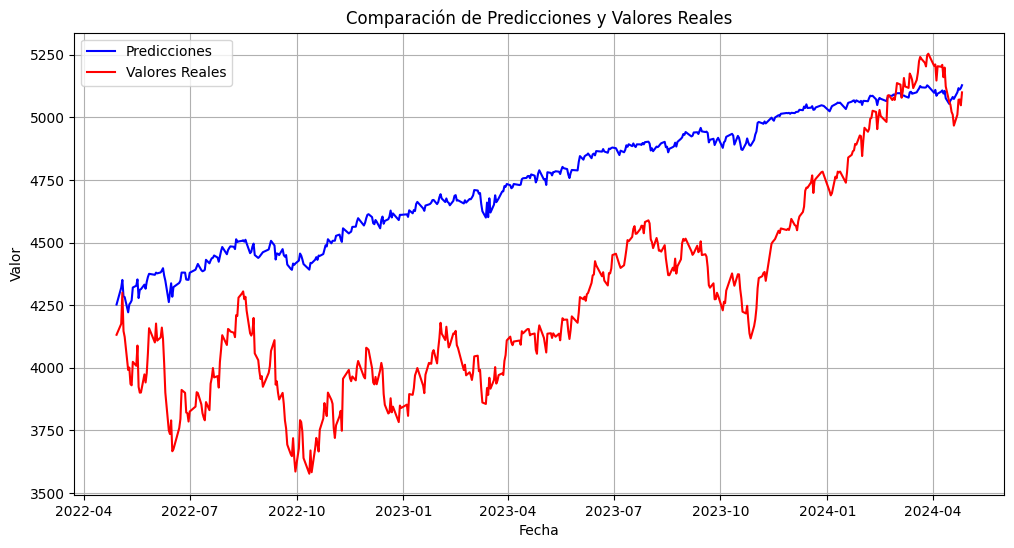

In [63]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Graficar las predicciones, asegurándote de usar el nombre correcto de la columna
plt.plot(predictions_arimax1_new_df.index, predictions_arimax1_new_df['Prediccion'], label='Predicciones', color='blue')

# Graficar los valores reales
plt.plot(y_test_arimax1_new_df.index, y_test_arimax1_new_df['Close'], label='Valores Reales', color='red')

# Añadir título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Añadir cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [64]:
sp500_ARIMA_DR= sp500_ARIMA.copy()
sp500_ARIMA_DR['Retornos_Diarios'] = sp500_ARIMA_DR['Close'].pct_change() * 100  # Multiplicado por 100 para obtener el porcentaje

# Para ver los primeros 5 retornos
print(sp500_ARIMA_DR['Retornos_Diarios'].head())

missing_values = sp500_ARIMA_DR.isnull().sum()
print(missing_values)


Date
2014-04-30         NaN
2014-05-01   -0.014326
2014-05-02   -0.134845
2014-05-05    0.187122
2014-05-06   -0.898839
Name: Retornos_Diarios, dtype: float64
Close               0
Retornos_Diarios    1
dtype: int64


In [65]:
# Eliminar filas que contengan valores nulos
sp500_ARIMA_DR_cleaned = sp500_ARIMA_DR.dropna()

# Verifica de nuevo si hay valores nulos
missing_values_cleaned = sp500_ARIMA_DR_cleaned.isnull().sum()
print(missing_values_cleaned)


Close               0
Retornos_Diarios    0
dtype: int64


In [66]:
# Divide los datos en conjuntos de entrenamiento y prueba (por ejemplo, 80% train, 20% test)
train_size_DR = int(len(sp500_ARIMA_DR_cleaned) * (1-test_size_Control))
train_data_DR = sp500_ARIMA_DR_cleaned['Retornos_Diarios'][:train_size_DR]
test_data_DR = sp500_ARIMA_DR_cleaned['Retornos_Diarios'][train_size_DR:]

In [67]:
import pmdarima as pm
# Entrena el modelo ARIMA en el conjunto de entrenamiento
model_DR = pm.auto_arima(train_data_DR, seasonal=False, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Guardar el modelo en un archivo binario
with open('model_arima_DR.pkl', 'wb') as pkl:
    pickle.dump(model_DR, pkl)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5953.789, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6137.511, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6078.085, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6088.010, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6065.221, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6067.857, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5955.335, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6062.782, Time=0.52 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6071.446, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6063.074, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6002.641, Time=0.33 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.00 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5951.407, Time=0.77 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6063.231, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : 

In [68]:
# Hacer predicciones para el conjunto de prueba
predictions_DR = model_DR.predict(n_periods=len(test_data_DR))


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [69]:
# Calcula el MSE y el RMSE
mse = mean_squared_error(test_data_DR, predictions_DR)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MSE: 1.2776532228776067
RMSE: 1.1303332353238167


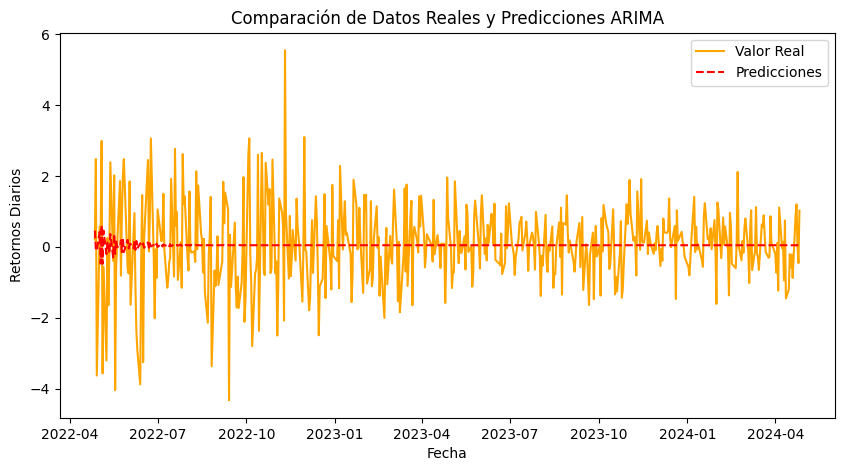

In [70]:
# Grafica los valores reales contra las predicciones
plt.figure(figsize=(10, 5))
#plt.plot(train_data_DR.index, train_data_DR, color='blue', label='Datos de Entrenamiento')
plt.plot(test_data_DR.index, test_data_DR, color='orange', label='Valor Real')
plt.plot(test_data_DR.index, predictions_DR, color='red', linestyle='--', label='Predicciones')
plt.title('Comparación de Datos Reales y Predicciones ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Retornos Diarios')
plt.legend()
plt.show()


### LINEA 17. Incorporar nuevos valores cómo afecta el output para interpretarlo

In [71]:
# Asumiendo que sp500_ARIMA es tu DataFrame y ya está definido

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size_arima2 = int(len(sp500_ARIMA) * (1-test_size_Control))
train_arima2, test_arima2 = sp500_ARIMA['Close'][:train_size_arima2], sp500_ARIMA['Close'][train_size_arima2:]

# Ajustar el modelo AutoARIMA
model_returns_arima2 = auto_arima(train_arima2, seasonal=False, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True)

# Guardar el modelo
pickle.dump(model_returns_arima2, open('ARIMA2_Close_best_model_returns.pkl', 'wb'))
print("Mejor modelo ARIMA2 guardado:")
print(model_returns_arima2.summary())

# Actualizar el modelo y realizar predicciones en el conjunto de prueba REVISAR CON PROFESOR
predicted_values_arima2 = []  # Lista para almacenar las predicciones
for new_val in test_arima2:
    model_arima2 = pickle.load(open('ARIMA2_Close_best_model_returns.pkl', 'rb'))  # Cargar el modelo
    model_arima2.update(new_val)  # Actualizar el modelo con el último valor real
    pred_arima2 = model_arima2.predict(n_periods=1)[0]  # Realizar la predicción para el próximo día
    predicted_values_arima2.append(pred_arima2)  # Almacenar la predicción

# Convertir la lista de predicciones a un array para cálculo de errores
predicted_values_array_arima2 = np.array(predicted_values_arima2)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test_arima2 = mean_squared_error(test_arima2, predicted_values_array_arima2)
rmse_test_arima2 = np.sqrt(mse_test_arima2)
mae_test_arima2 = mean_absolute_error(test_arima2, predicted_values_array_arima2)

print(f'ARIMA2 Test - MSE: {mse_test_arima2}, RMSE: {rmse_test_arima2}, MAE: {mae_test_arima2}')

# Crear y guardar DataFrames
test_df_arima2 = pd.DataFrame({'Fecha': pd.to_datetime(sp500_ARIMA.index[train_size_arima2:]), 'Valor_Real': test_arima2, 'Prediccion': predicted_values_array_arima2})
#test_df_arima2.to_csv('ARIMA2_test_vs_predicciones.csv', index=False)

#valores_reales_df_arima2 = test_df_arima2[['Fecha', 'Valor_Real']]
#valores_reales_df_arima2.to_csv('ARIMA2_valores_reales_test.csv', index=False)

# Generar nombre de archivo con variables incluidas
nombre_archivo_predicciones = f'ARIMA2_test_vs_predicciones_{fecha_inicio}_testsize{test_size_Control}.csv'

# Guardar DataFrame de predicciones
#test_df_arima2.to_csv(nombre_archivo_predicciones, index=False)

# Crear DataFrame solo con valores reales
valores_reales_df_arima2 = test_df_arima2[['Fecha', 'Valor_Real']]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19520.315, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19659.310, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19623.572, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19628.412, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19660.121, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19617.672, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19618.720, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19618.572, Time=1.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19618.609, Time=1.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19619.833, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19617.485, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19568.962, Time=0.89 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19523.818, Time=1.59 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=19521.703, Time=0.52 sec

Best model:  ARIMA

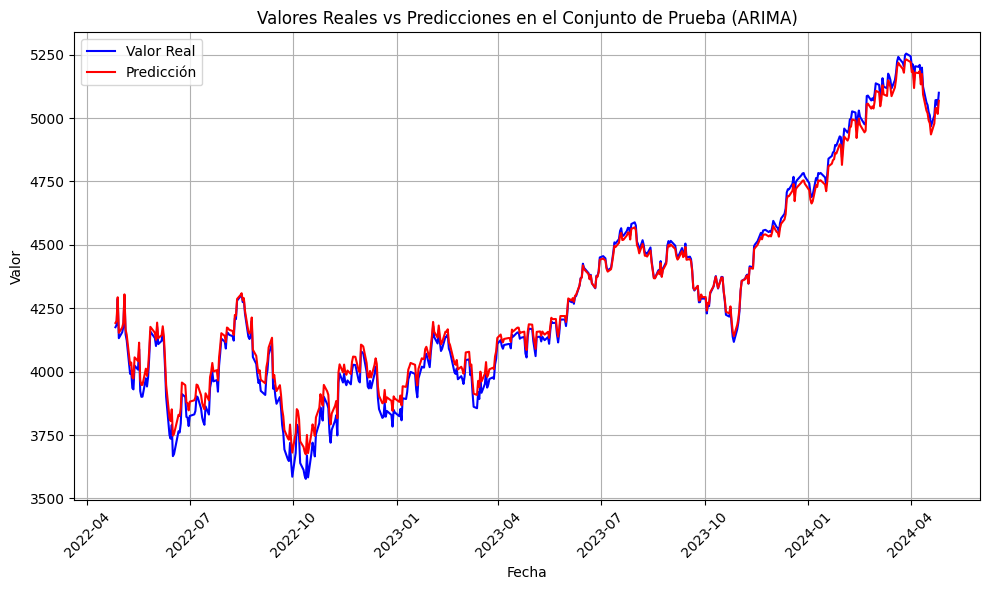

In [72]:
import matplotlib.pyplot as plt

# Graficar los valores reales y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(test_df_arima2['Fecha'], test_df_arima2['Valor_Real'], label='Valor Real', color='blue')
plt.plot(test_df_arima2['Fecha'], test_df_arima2['Prediccion'], label='Predicción', color='red')
plt.title('Valores Reales vs Predicciones en el Conjunto de Prueba (ARIMA)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Guardar la gráfica
plt.savefig('ARIMA2_predicciones_vs_valores_reales.png')

# Mostrar la gráfica
plt.show()
